# State of the Union Analyses
***

## Background

The State of the Union (SotU) is a annual message delivered by the president of the United States to the Congress. It is a chance for the president to speak to the nation and make a case for their agenda and current administration. The speech lays out the priorities for an administration and president, as well as the overall health, especially economic, of the nation. Major issues of the day are addressed. 

For this project we have the transcribed speeches of each SotU between 1945 and 2016. The time period covers 12 different presidents, 6 Democrats and 6 Republicans. The raw text for each speech can be found [here](https://github.com/Zach-Berman/NLP-State-of-the-Union/blob/master/state-of-the-union-corpus.zip).

## Questions

The president is mandated by the Constitution to give a SotU speech every single year; and given that the SotU is perhaps the most important political speech given each and every year, we have a wealth of data to dive into. Using NLP algorithms, we are able to break down and analyze each speech in great detail to try to detect patterns and trends. This project will focus on answering the following questions in order to give this project direction:

1. Are there variations in tone or sentiment between presidents?
2. What could account for changes in sentiment in each SotU? Are there indictors which could predict sentiment?
3. How does the language used in these speeches change over time, and are their noticeable patterns?
4. Are there major differences in the speeches given between presidents of the two different political parties.

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import spacy
from textblob import TextBlob
%matplotlib inline
import warnings
#warnings.simplefilter(action='ignore', category=[FutureWarning, RuntimeWarning])

In [2]:
# import all the SOTU txt files
data_folder = 'state-of-the-union-corpus-1989-2024'
file_list = [f for f in os.listdir(data_folder) if not f.startswith(".")]

# create lists for the year and president who gave the speech
years = []
potus = []
for file in file_list:
    year = file[:4]
    pres = file[5:-4]
    pres = re.sub('[^a-zA-Z]+', '', pres)
    years.append(year)
    potus.append(pres)

In [3]:
# create dataframe
df = pd.DataFrame(file_list, columns=['path'])
df['year'] = years
df['year'] = df['year'].astype(int)
df['president'] = potus

# add state-of-the-union-corpus-1989-2024 to the beginning of each path
df['path'] = data_folder + '/' + df['path']

# create a list of Democrat presidents
dems = ['Truman', 'Kennedy', 'Johnson', 'Carter', 'Clinton', 'Obama']

# add party affiliation to the dataframe
df['party'] = df.president.apply(lambda x: 'Democrat' if x in dems else 'Republican')

In [4]:
# use textblob to tokenize the words in each speech
df['tokens'] = df.path.apply(lambda x: TextBlob(open(x, encoding='ISO-8859-1').read()).words)

# use textblob to perform a sentiment analysis of each speech
df['sentiment'] = df.path.apply(lambda x: TextBlob(open(x, encoding='ISO-8859-1').read()).sentiment.polarity)

In [5]:
# import GDP growth and unemployment data and merge with main dataframe
economic_df = pd.read_csv('gdp_data.csv')
# convert 12/31/2017 to year
economic_df['year'] = economic_df['Date'].apply(lambda x: x[6:])
economic_df['year'] = economic_df['year'].astype(int)
# rename GDP Growth Rate to gdp_rate
economic_df.rename(columns={'GDP Growth Rate':'gdp_rate'}, inplace=True)
# drop date
economic_df.drop('Date', axis=1, inplace=True)
df = df.merge(economic_df, how="left", on="year")
unemployment_df = pd.read_csv('unemployment_data.csv')
# rename Rate to unemployment_rate, Year to year
unemployment_df.rename(columns={'Rate':'unemployment_rate', 'Year':'year'}, inplace=True)
df = df.merge(unemployment_df, how='left', on='year')
df['unemployment_rate'] = df['unemployment_rate']*100
df['gdp_rate'] = df['gdp_rate']*100

# re index the dataframe by year
df = df.sort_values(by="year").reset_index(drop=True)

# delete temp dataframes
del economic_df
del unemployment_df

In [6]:
#check data types and display dataframe
print(df.shape)
print(df.dtypes)
df.head()

(81, 8)
path                  object
year                   int64
president             object
party                 object
tokens                object
sentiment            float64
gdp_rate             float64
unemployment_rate    float64
dtype: object


path  year president  \
0  state-of-the-union-corpus-1989-2024/1945-Truma...  1945    Truman   
1  state-of-the-union-corpus-1989-2024/1946-Truma...  1946    Truman   
2  state-of-the-union-corpus-1989-2024/1947-Truma...  1947    Truman   
3  state-of-the-union-corpus-1989-2024/1948-Truma...  1948    Truman   
4  state-of-the-union-corpus-1989-2024/1949-Truma...  1949    Truman   

      party                                             tokens  sentiment  \
0  Democrat  [PRESIDENT, HARRY, S, TRUMAN, 'S, ADDRESS, BEF...   0.103764   
1  Democrat  [PRESIDENT, HARRY, S, TRUMAN, 'S, MESSAGE, TO,...   0.111545   
2  Democrat  [PRESIDENT, HARRY, S, TRUMAN, 'S, ANNUAL, MESS...   0.136731   
3  Democrat  [PRESIDENT, HARRY, S, TRUMAN, 'S, ANNUAL, MESS...   0.165403   
4  Democrat  [PRESIDENT, HARRY, S, TRUMAN, 'S, ANNUAL, MESS...   0.155075   

   gdp_rate  unemployment_rate  
0     11.45                1.9  
1     10.67                3.9  
2     -0.01                3.9  
3      3.80                4.0  
4     -1.50                6.6

## Sentiment Analysis

A sentiment analysis analyzes each token in from language data and assigns them a rating based on how positive or negative the connotation of that token is. In this instance, the scale goes from -1 to 1 with -1 being the most negative words possible and 1 being the words with a very positive meaning. For example, the word 'great' would have a higher score than 'good, and the word 'awful' would have a lower score than the word 'bad'. Words with no positive or negative leanings are given a score of zero and not factored into the analysis. The package TextBlob has a built in algorithm which has a long list of words already scored, and I will be utilizing that feature.

Below, you can see the sentiment analysis grouped by president. Every SotU has had an overall positive sentiment ranging from .08 to .20. The SotU must strike a careful balance. On one hand, the SotU is a reflection of an administration and the health of the nation, and therefore the president would not want to overly negative, as people would assume the administration is doing a poor job. On the other hand, if the SotU is too optimistic or positive, an administration could come off as out of touch to the suffering of certain sectors of the populous, alienating them. It seems the strategy is to find a balance of, what I will call 'cautious optimism.' Things are going well, but there is always room for improvement.

How these sentiments changed throughout a presidency is also worth noting. Of the 14 presidents included here, 8 had their sentiment scores increase over time. Of the Democrats, only Kennedy and Biden showed a negative trend in sentiment, that was very minor. Conversely, the Republican presidents were split evenly, half trending positive and half negative.

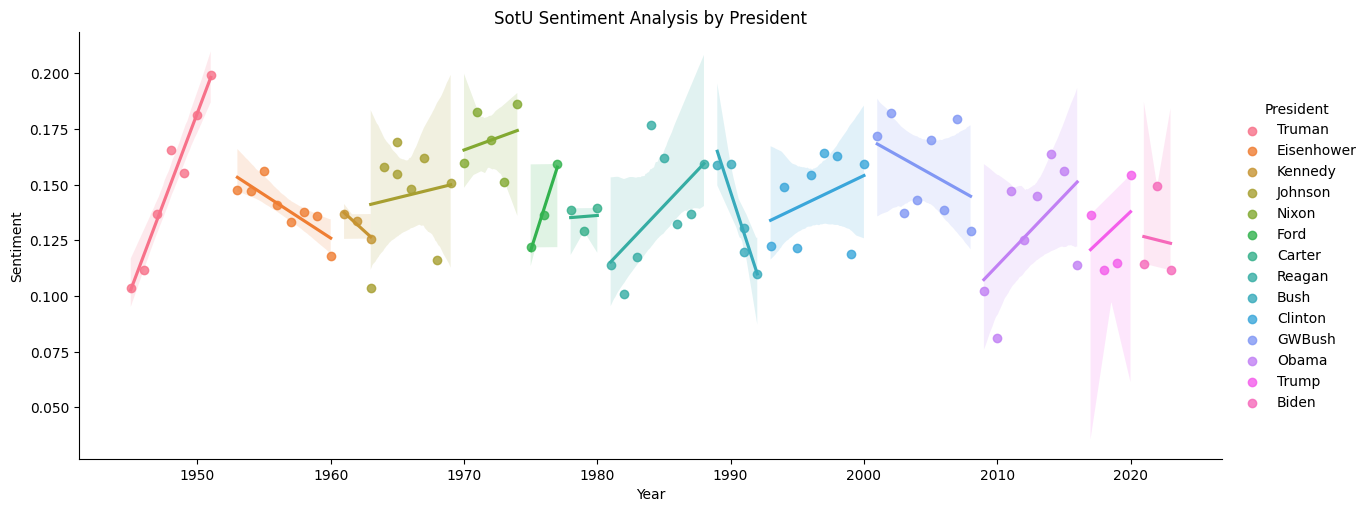

In [7]:
# plot sentiment analysis data

# Create the plot with sorted hue
g = sns.lmplot(
    x="year", y="sentiment", hue="president", aspect=2.5, truncate=True, data=df
)
g._legend.set_title("President")

plt.xlabel("Year")
plt.ylabel("Sentiment")
plt.title("SotU Sentiment Analysis by President")

plt.show()

## Economic Factors

Each presidency has to deal with a unique set of issues and challenges, but one constant is the state of the economy. I wanted to take a surface level look at some important economic indicators to see if there was any correlation between changing sentiment. Two of the major economic indicators for the economy are the GDP growth rate and the unemployment rate. Below I have created identical style graphs for visual comparison. A visual analysis seems to show that there isn't much correlation between GDP and sentiment. If there was a correlation, you would expect to see sentiment increasing as GDP rates increased. However, you there does appear to be an inverse correlation between unemployment and sentiment. As unemployment rates decrease, sentiment appears to be increasing. Of course, we can do more than just visual inspect this data.

In order to run a correlation analysis, we have to check if our features have normal distributions. All three populations show distributions normal enough to run a pearson correlation analysis. To visualize the relationships between the populations, scatterplots have been created. You can see that there is almost no trend between sentiment and GDP rates, while there is an inverse trend between unemployment and sentiment. The pearson correlation backs up these trends. The relationship between unemployment and sentiment has an r-value of -0.27 and a p-value of 0.016. We need to be wary of making any causal claims, this is just a correlation. Also, p-values in pearson tests aren't as reliable with populations under around 500. More economic data would help establish an actual relationship with a regression. However, if unemployment is going up, we would expect the SotU to be less optimistic as more voters are out of work and probably not very happy.

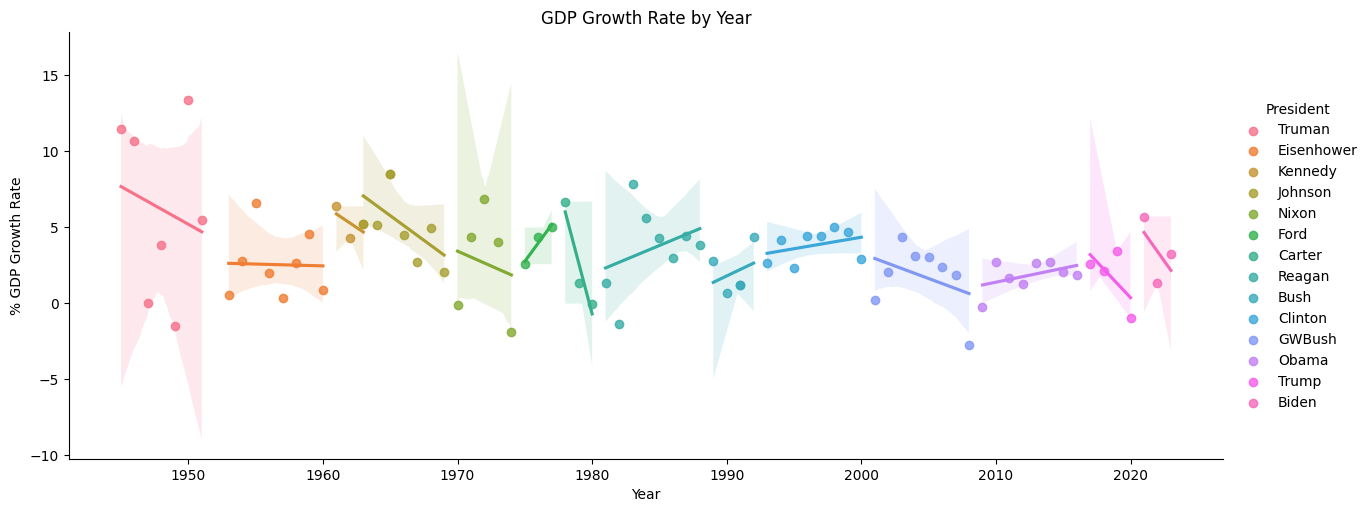

In [8]:
#plot GDP growth data
g1 = sns.lmplot(x="year", y="gdp_rate", hue="president", aspect=2.5, truncate=True, data=df)
g1._legend.set_title('President')
plt.xlabel('Year')
plt.ylabel('% GDP Growth Rate')
plt.title('GDP Growth Rate by Year')

plt.show()

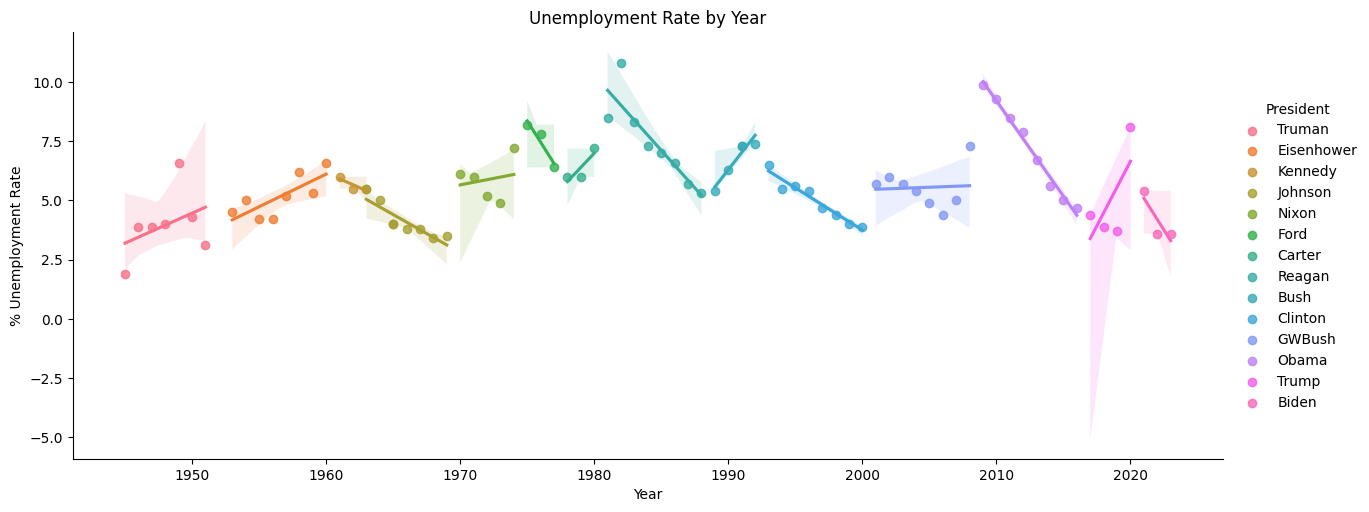

In [9]:
#plot unemployment rate  data
g2 = sns.lmplot(x="year", y="unemployment_rate", hue="president", aspect=2.5, truncate=True, data=df)
g2._legend.set_title('President')
plt.xlabel('Year')
plt.ylabel('% Unemployment Rate')
plt.title('Unemployment Rate by Year')

plt.show()

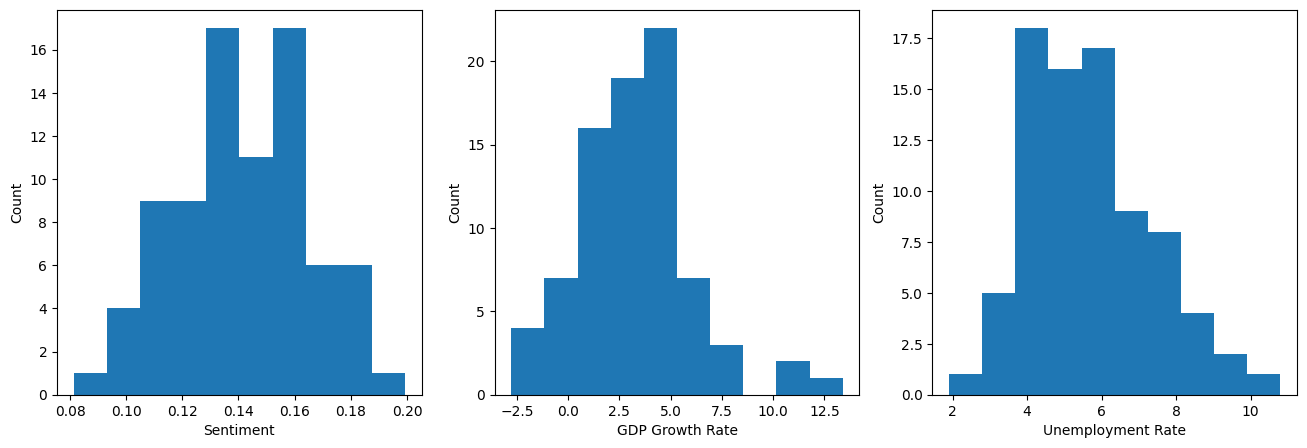

In [10]:
plt.figure(figsize=(16, 5))

plt.subplot(131)
plt.hist(df.sentiment)
plt.xlabel('Sentiment')
plt.ylabel('Count')

plt.subplot(132)
plt.hist(df.gdp_rate)
plt.xlabel('GDP Growth Rate')
plt.ylabel('Count')

plt.subplot(133)
plt.hist(df.unemployment_rate)
plt.xlabel('Unemployment Rate')
plt.ylabel('Count')

plt.show()

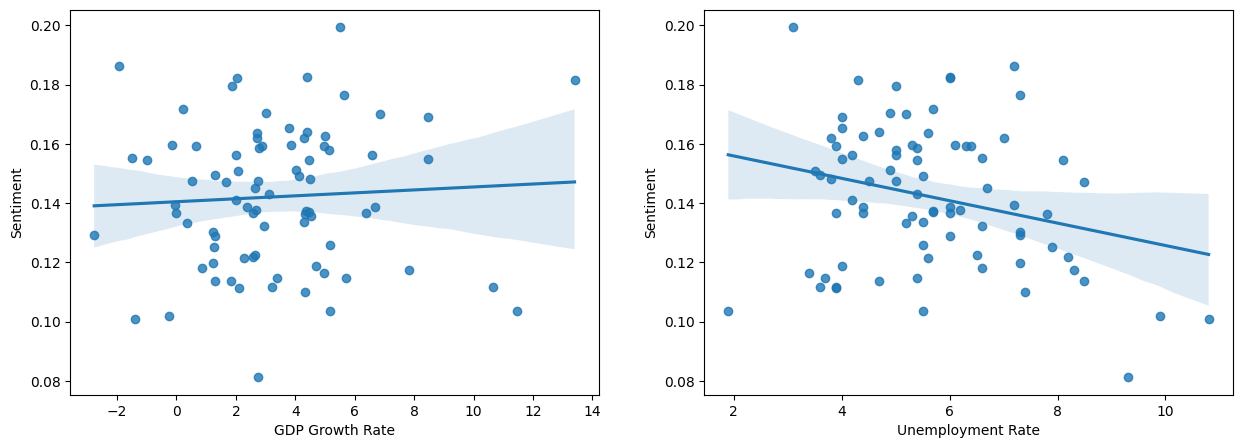

In [11]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
sns.regplot(x=df['gdp_rate'], y=df['sentiment'])
plt.xlabel('GDP Growth Rate')
plt.ylabel('Sentiment')

plt.subplot(122)
sns.regplot(x=df['unemployment_rate'], y=df['sentiment'])
plt.xlabel('Unemployment Rate')
plt.ylabel('Sentiment')

plt.show()

In [12]:
from scipy.stats import pearsonr

print('Sentiment-GDP Correleation:', pearsonr(df.sentiment, df.gdp_rate))
print('Sentiment-Unemployment Correleation:', pearsonr(df.sentiment, df.unemployment_rate))

Sentiment-GDP Correleation: PearsonRResult(statistic=np.float64(0.06024595959639101), pvalue=np.float64(0.5931535000622122))
Sentiment-Unemployment Correleation: PearsonRResult(statistic=np.float64(-0.26593866380842063), pvalue=np.float64(0.016411662157805686))


## Most Common Words

Psychology has shown that the more often a word or phrase is used in a speech, the more it sticks with an audience. As such, the key, defining themes of a speech can often be derived by looking at the most commonly used words. Here, the spaCy package is implemented to tokenize each speech once again. This analysis could also be done via TextBlob, however spaCy offers a more robust tool set for this particular feature. The speeches are cleaned up and stop words are removed from the analysis. For this project, I am only analyzing the 20 most common words for each speech, but any word could be analyzed here. If you wanted to look at economic terms like job, inflation, etc., you could do that as well.

Word clouds were created for each speech to make visualizing the shifts in language more appealing. A write up on the thematic shifts by president, or by era, or inside a presidency itself could probably fill a book. Take the time to scan through and find patterns. See if you can notice when large global events have occurred (wars, recessions, booms).

In this particular project, I am interested in seeing if presidents of different parties have unique ways of speaking or common themes they use over time. As such, clustering models will be utilized.

In [13]:
# utility function to clean text
def text_cleaner(text):
    # Replace double dash '--' with a space
    text = re.sub(r"--", " ", text)

    # Remove headings in brackets
    text = re.sub(r"\[.*?\]", "", text)

    # Remove extra whitespace
    text = " ".join(text.split())

    return text

In [14]:
#load spacy model
nlp = spacy.load('en_core_web_sm')

#add features with text for each speech and run through the text cleaner
df['text'] = df.path.apply(lambda x: open(x, encoding='ISO-8859-1').read())
df['text'] = df.text.apply(lambda x: text_cleaner(x))

In [15]:
df['nlp'] = df.text.apply(lambda x: nlp(x))
df.head()

path  year president  \
0  state-of-the-union-corpus-1989-2024/1945-Truma...  1945    Truman   
1  state-of-the-union-corpus-1989-2024/1946-Truma...  1946    Truman   
2  state-of-the-union-corpus-1989-2024/1947-Truma...  1947    Truman   
3  state-of-the-union-corpus-1989-2024/1948-Truma...  1948    Truman   
4  state-of-the-union-corpus-1989-2024/1949-Truma...  1949    Truman   

      party                                             tokens  sentiment  \
0  Democrat  [PRESIDENT, HARRY, S, TRUMAN, 'S, ADDRESS, BEF...   0.103764   
1  Democrat  [PRESIDENT, HARRY, S, TRUMAN, 'S, MESSAGE, TO,...   0.111545   
2  Democrat  [PRESIDENT, HARRY, S, TRUMAN, 'S, ANNUAL, MESS...   0.136731   
3  Democrat  [PRESIDENT, HARRY, S, TRUMAN, 'S, ANNUAL, MESS...   0.165403   
4  Democrat  [PRESIDENT, HARRY, S, TRUMAN, 'S, ANNUAL, MESS...   0.155075   

   gdp_rate  unemployment_rate  \
0     11.45                1.9   
1     10.67                3.9   
2     -0.01                3.9   
3      3.80                4.0   
4     -1.50                6.6   

                                                text  \
0  PRESIDENT HARRY S. TRUMAN'S ADDRESS BEFORE A J...   
1  PRESIDENT HARRY S. TRUMAN'S MESSAGE TO THE CON...   
2  PRESIDENT HARRY S. TRUMAN'S ANNUAL MESSAGE TO ...   
3  PRESIDENT HARRY S. TRUMAN'S ANNUAL MESSAGE TO ...   
4  PRESIDENT HARRY S. TRUMAN'S ANNUAL MESSAGE TO ...   

                                                 nlp  
0  (PRESIDENT, HARRY, S., TRUMAN, 'S, ADDRESS, BE...  
1  (PRESIDENT, HARRY, S., TRUMAN, 'S, MESSAGE, TO...  
2  (PRESIDENT, HARRY, S., TRUMAN, 'S, ANNUAL, MES...  
3  (PRESIDENT, HARRY, S., TRUMAN, 'S, ANNUAL, MES...  
4  (PRESIDENT, HARRY, S., TRUMAN, 'S, ANNUAL, MES...

In [16]:
from collections import Counter
# save a list of stop words
stop_words = stopwords.words('english')

# utility function that retuns a list of the most common words
def word_frequencies(text, include_stop=False):
    
    # Build a list of words.
    # Strip out punctuation and, optionally, stop words.
    words = []
    for token in text:
        #exclude punctuation, numeric characters and words in the stop list
        if not token.is_punct and token.is_alpha and not token.is_stop and token.lower_ not in stop_words:
            words.append(token.text)
            
    # Build and return a Counter object containing word counts.
    return Counter(words)

In [42]:
from wordcloud import WordCloud

# Function to create word clouds for each speech
def word_clouds(text_list, df):
    num_items = len(text_list)
    cols = 3  # Number of columns
    rows = (num_items + cols - 1) // cols  

    plt.figure(figsize=(15, rows*3))  
    for n, texts in enumerate(text_list):
        plt.subplot(rows, cols, n + 1) 
        wordcloud = WordCloud(stopwords=stop_words, max_words=20).generate(texts)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.title(f"{df.president[n]} {df.year[n]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

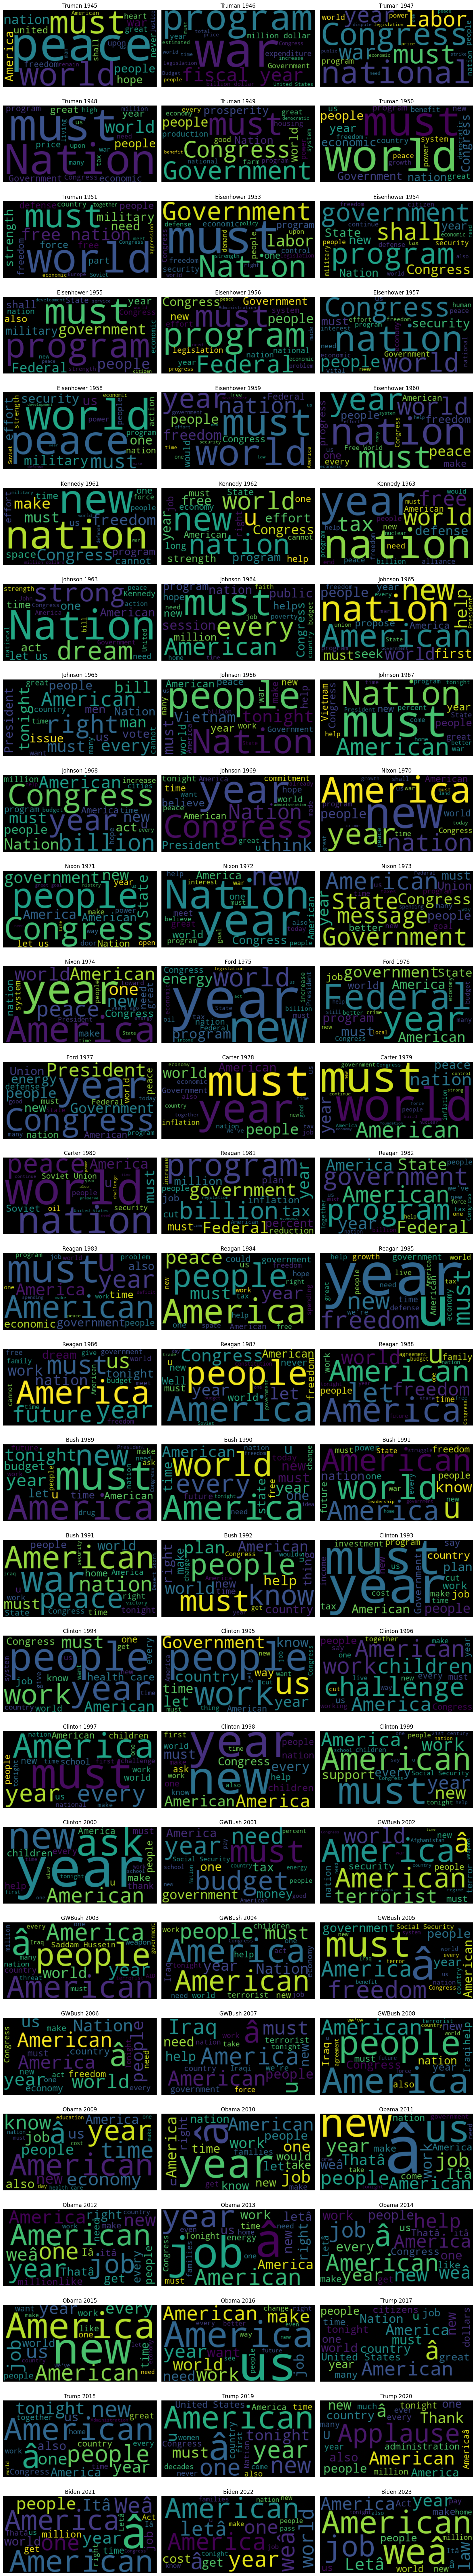

In [43]:
word_clouds(df.text, df)

## Preparing Language Data for Analysis

Before any sort of clustering analysis can be done, the language used in each speech needs to turned into numeric data. To do this a TF-IDF Vectorizer can be utilized. TF-IDF (term frequency-inverse document frequency) is a numerical statistic that reflects how important a word is to a document or group of documents, in this instance all the SotUs. A word's TF-IDF value increase proportionally to the number of times a word is used in a speech, and is then offset by the number of times that same word is used across all the speeches. A words that is used frequently in most of the speeches will have a lower value than a word that is used frequently in only a few speeches. We dropped words that appeared in more than half the speeches, and a word had to appear at least 5 times. These are the standard numbers used for this kind of analysis but they can be changed to look at more rare or more common words.

The speeches were divided into training and test sets and then run through our vectorizer. 4146 features were derived from this process. That is a lot of features and a lot of dimensionality to work with on a local machine. To "simplify" or analysis, we can reduce the number of features using truncated singular value decomposition or SVD. SVDs work like PCA, but contrary to PCA, SVD does not center the data first. We reduced the number of dimensions down to 65. Our SVD algorithm was able to explain 93% of the variance in the vectorized data.

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from nltk.corpus import stopwords

X_train, X_test, y_train, y_test = train_test_split(df.text, df.path, test_size=0.4, random_state=0)

#build TFIDF vectorizer
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than 75% the speeches
                             min_df=5, # only use words that appear at least five times
                             stop_words='english', #remove stop words
                             lowercase=True, #convert everything to lower case
                             use_idf=True,#inverse document frequencies in our weighting
                             norm=u'l2', #a correction factor so that longer and shorter speeches get treated equally
                             smooth_idf=True #prevents divide-by-zero errors
                            )

In [20]:
#Applying the vectorizer
sotus_tfidf = vectorizer.fit_transform(df.text)
print("Number of features: %d" % sotus_tfidf.get_shape()[1])

Number of features: 4146


In [21]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 4146 to 65.
svd= TruncatedSVD(65)
lsa = make_pipeline(svd, Normalizer(copy=False))
#Run SVD on the sotus data, then project
sotus_lsa = lsa.fit_transform(sotus_tfidf)
explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))

xs, ys = sotus_lsa[:, 0], sotus_lsa[:, 1]

Explained variance of the SVD step: 90%


In [22]:
file_list = []
for paths in df.path:
    file = os.path.basename(paths)
    # Alternatively, with Path:
    # file = Path(paths).name
    file_list.append(file)

# For feature names
terms = vectorizer.get_feature_names_out()

## Clustering Analysis

After getting our original data vectorized and set for prepared for analysis, we can run clustering models to see if there actually is a difference between Democrat and Republican presidents. K-Means clustering was used and 2 clusters were selected (2 parties, 2 clusters). Our first attempt at clustering shows that presidents from each party are interspersed. So what else could be creating our clusters? Changed the labels from party to the individual speech gives us an answer. The clusters are not created by party, but more along what time frame they were made. Speeches by president seem to group, but a speech by a Republican from before 1980 is more similar to a speech from a Democrat from the same era, than a Republican from after 1980. The way politicians and presidents have been speaking has seemed to change more over time. Or it could suggest a political shift in the parties.

Perhaps we can get political parties to pop out if we increase our clusters to 4, allowing for the time era and political parties. Here the K-means clustering analysis becomes less clear. There are some patterns, that emerge however, for the most part, the pre 1980 cluster is preserved. Post 1980s is divided into two clusters, with one being mostly post 2000s with the exception of some Obama speeches presidents other having the remaining presidents. The final cluster is almost entirely comprised of speeches given by LBJ.

A spectral clustering analysis was run as well, and this differed from the K-means analysis. The spectral analysis focused more on creating more time frames, rather than the rough 3-4 from the previous step, it found 4 groups consisting of speeches by GW Bush, pre 1980s presidents, post 2000s Democrats, and post 1980 Republicans, respectively.

In [23]:
#build a Kmeans cluster with two clusters
km = KMeans(n_clusters=2, random_state=42)
km.fit(sotus_tfidf)
clusters = km.labels_.tolist()

df['cluster'] = clusters

In [24]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(2):
    print("Cluster %d words:" % i, end=' ')
    
    for ind in order_centroids[i, :20]: #replace 6 with n words per cluster
        print(terms[ind], end=', ')
    print('\n')

Top terms per cluster:

Cluster 0 words: shall, recommend, expenditures, fiscal, farm, vietnam, reduction, recommendations, communist, space, employment, management, peoples, total, adequate, aggression, commission, period, relations, increases, 

Cluster 1 words: weâ, iraq, letâ, thatâ, iâ, itâ, terrorists, ll, college, americaâ, don, medicare, 21st, class, companies, iraqi, terror, al, kids, got, 



In [25]:
#create data frame that has the cluster numbers and titles
kmean_df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=file_list, party=df.party)) 

#group by cluster
groups = kmean_df.groupby('label')

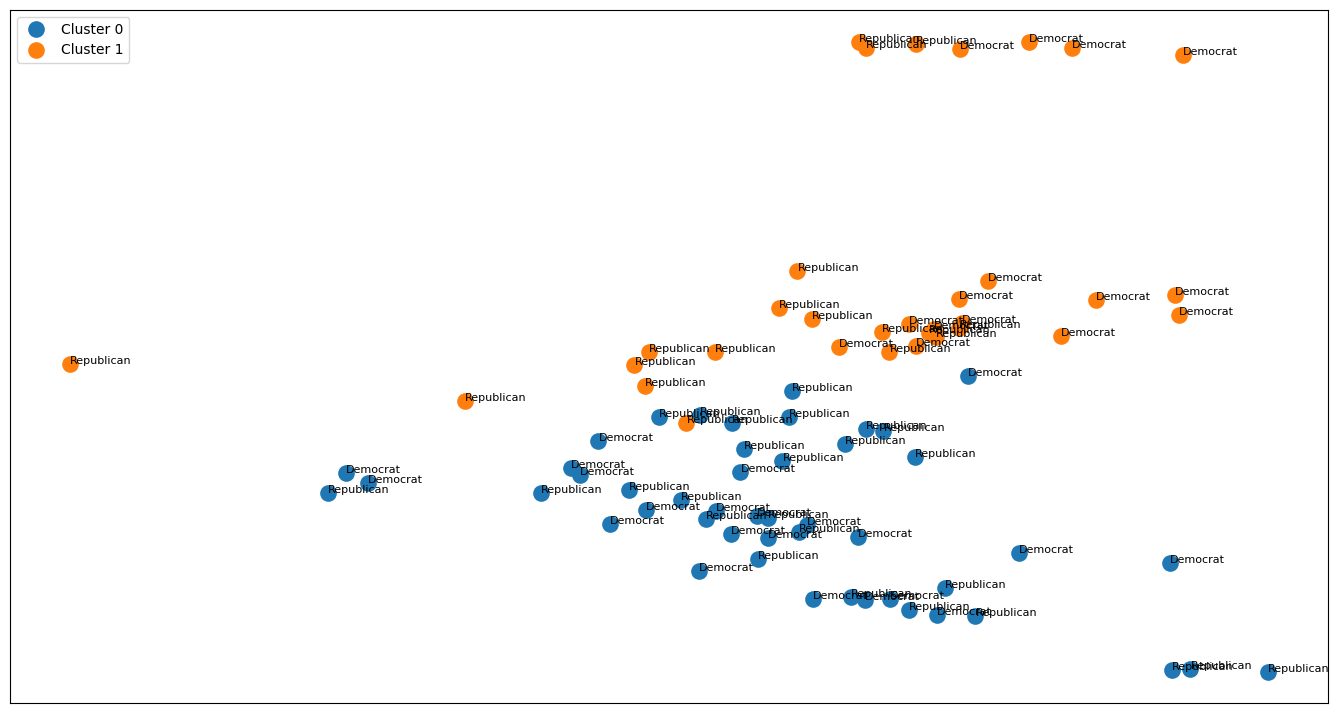

In [26]:
cluster_names_0 = {0: 'Cluster 0', 1: 'Cluster 1'}
# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names_0[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          
        which='both',       #both major and minor ticks are affected
        bottom=False,      
        top=False,         
        labelbottom=False)
    ax.tick_params(\
        axis= 'y',         
        which='both',     
        left=False,      
        top=False,         
        labelleft=False)
    
ax.legend(numpoints=1, loc='upper left')  #show legend with only 1 point

#add label in x,y position with the label as the speech title
for i in range(len(df)):
    ax.text(kmean_df.loc[i]['x'], kmean_df.loc[i]['y'], kmean_df.loc[i]['party'], size=8)  

    
    
plt.show()

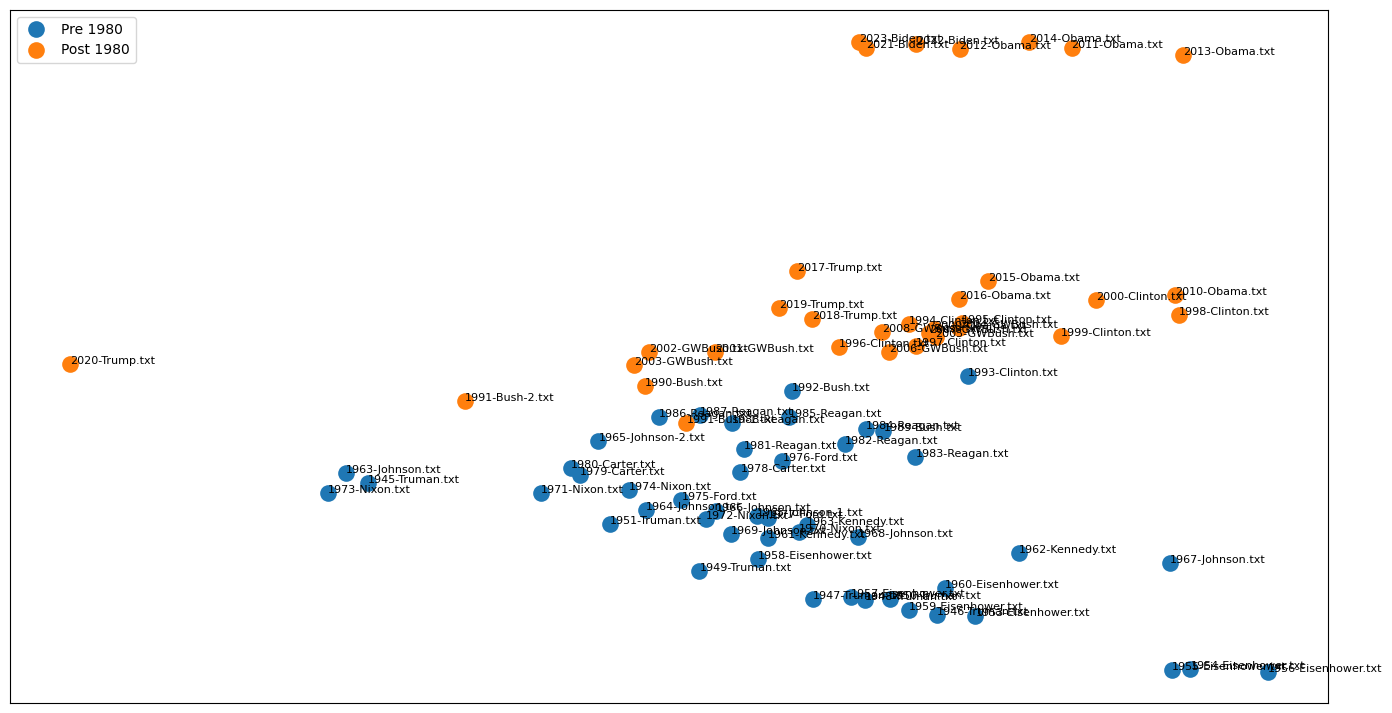

In [27]:
cluster_names = {0: 'Pre 1980', 1: 'Post 1980'}

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], #color='blues',
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          
        which='both',       #both major and minor ticks are affected
        bottom=False,      
        top=False,         
        labelbottom=False)
    ax.tick_params(\
        axis= 'y',         
        which='both',     
        left=False,      
        top=False,         
        labelleft=False)
    
ax.legend(numpoints=1, loc='upper left')  #show legend with only 1 point

#add label in x,y position with the label as the speech title
for i in range(len(df)):
    ax.text(kmean_df.loc[i]['x'], kmean_df.loc[i]['y'], kmean_df.loc[i]['title'], size=8)  

    
    
plt.show()

In [28]:
#Kmeans with 4 clusters
km1 = KMeans(n_clusters=4, random_state=420)
km1.fit(sotus_tfidf)
clusters1 = km1.labels_.tolist()

df['cluster1'] = clusters1

In [29]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids1 = km1.cluster_centers_.argsort()[:, ::-1] 

for i in range(4):
    print("Cluster %d words:" % i, end=' ')
    
    for ind in order_centroids1[i, :20]: #replace 6 with n words per cluster
        print(terms[ind], end=', ')
    print('\n')

Top terms per cluster:

Cluster 0 words: vietnam, shall, kennedy, commitments, recommend, 1964, south, try, dream, hopes, john, color, expenditures, pending, employment, fiscal, communist, hate, north, johnson, 

Cluster 1 words: shall, farm, expenditures, fiscal, recommend, recommendations, peoples, management, communist, period, xand, adequate, oil, relations, capacity, aggression, employment, affairs, increases, organization, 

Cluster 2 words: weâ, letâ, thatâ, iâ, itâ, iraq, americaâ, terrorists, iraqi, terror, al, applause, afghanistan, donâ, border, qaeda, immigration, ll, terrorist, canâ, 

Cluster 3 words: don, ll, college, 21st, tell, bipartisan, thing, recovery, cuts, ought, got, won, big, kids, drugs, global, deficits, space, class, yes, 



In [30]:
cluster_names1 = {0: 'LBJ', 1: 'Pre 1980', 2: 'Post 2000', 3: 'Pre 2000'}

#create data frame that has the cluster numbers and titles
kmean_df1 = pd.DataFrame(dict(x=xs, y=ys, label=clusters1, title=file_list, party=df.party)) 

#group by cluster
groups1 = kmean_df1.groupby('label')

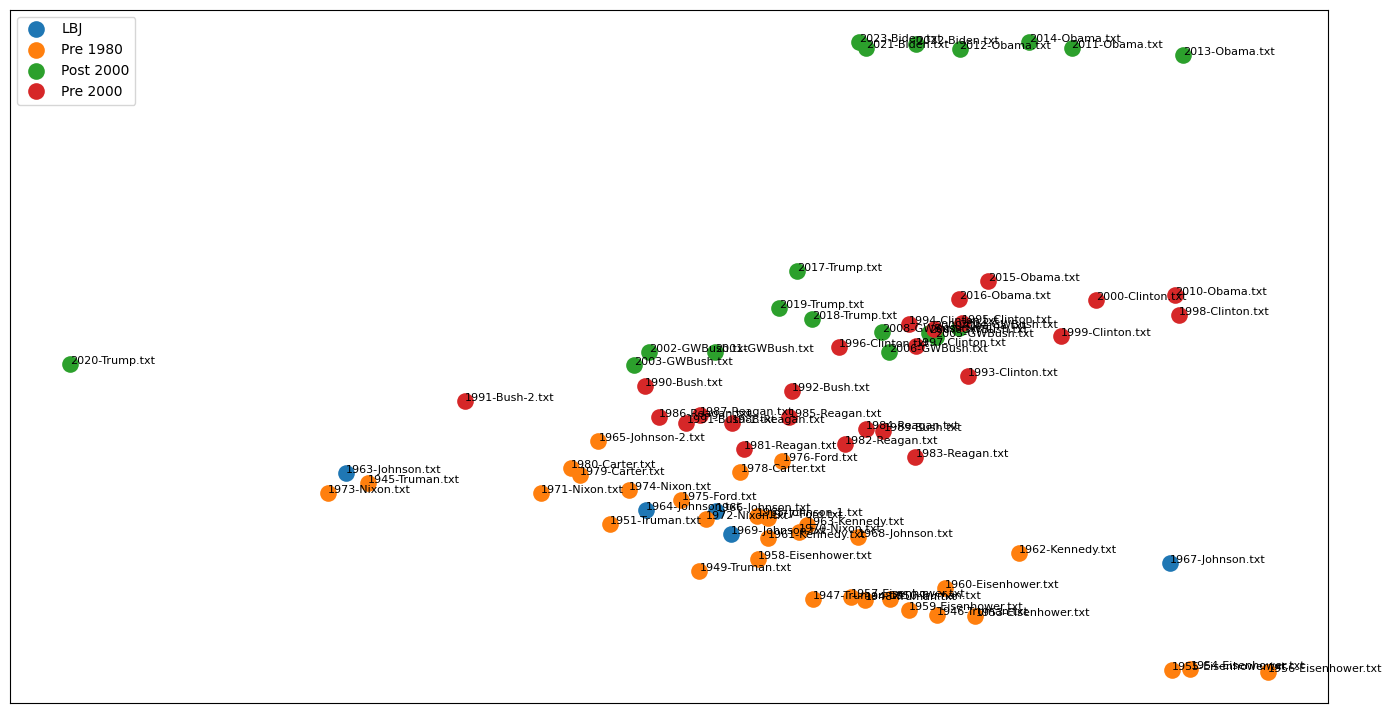

In [31]:
# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
for name, group in groups1:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names1[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          
        which='both',       #both major and minor ticks are affected
        bottom=False,      
        top=False,         
        labelbottom=False)
    ax.tick_params(\
        axis= 'y',         
        which='both',     
        left=False,      
        top=False,         
        labelleft=False)
    
ax.legend(numpoints=1, loc='upper left')  #show legend with only 1 point

#add label in x,y position with the label as the speech title
for i in range(len(df)):
    ax.text(kmean_df1.loc[i]['x'], kmean_df1.loc[i]['y'], kmean_df1.loc[i]['title'], size=8)  

    
    
plt.show()

In [32]:
from sklearn.cluster import SpectralClustering

#set up a spectral clustering model using 4 clusters
sc = SpectralClustering(n_clusters=4, random_state=1337)
sc.fit(sotus_tfidf)

#Predicted clusters.
predict=sc.fit_predict(sotus_tfidf)

clusters2 = sc.labels_.tolist()

In [33]:
cluster_names2 = {0: 'GW Bush', 1: 'Pre 1980', 2: 'Post 2000s Democrats', 3: 'Post 1980 Republicans'}

#create data frame that has the result of the MDS plus the cluster numbers and titles
sc_df = pd.DataFrame(dict(x=xs, y=ys, label=clusters2, title=file_list, party=df.party)) 

#group by cluster
groups2 = sc_df.groupby('label')

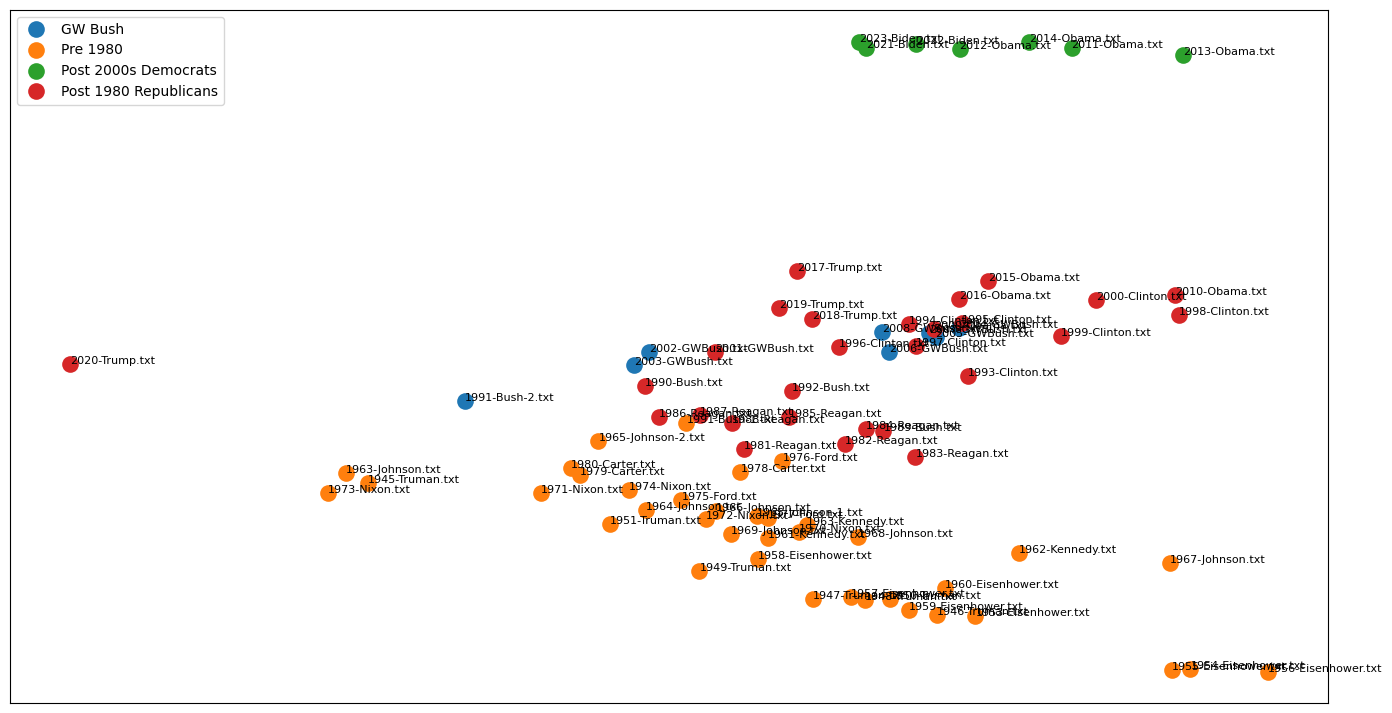

In [34]:
# set up plot
fig, ax = plt.subplots(figsize=(17, 9))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
for name, group in groups2:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names2[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          
        which='both',       #both major and minor ticks are affected
        bottom=False,      
        top=False,         
        labelbottom=False)
    ax.tick_params(\
        axis= 'y',         
        which='both',     
        left=False,      
        top=False,         
        labelleft=False)
    
ax.legend(numpoints=1, loc='upper left')  #show legend with only 1 point

#add label in x,y position with the label as the speech title
for i in range(len(df)):
    ax.text(sc_df.loc[i]['x'], sc_df.loc[i]['y'], sc_df.loc[i]['title'], size=8)  

    
    
plt.show()